<a href="https://colab.research.google.com/github/wose70/HDB_Rental/blob/main/DL_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading datasets...
Preprocessing rental data...
Calculating distances to MRT stations...


<ipython-input-2-d435fa44d52f>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rental_df['nearest_mrt_km'] = rental_df.apply(find_nearest_mrt, axis=1)


Creating visualizations...
Preparing data for modeling...
Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2555338.5000 - mae: 1222.6440 - val_loss: 472315.4375 - val_mae: 576.8013
Epoch 2/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 578930.0625 - mae: 623.1506 - val_loss: 460733.3125 - val_mae: 571.9818
Epoch 3/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 563067.5000 - mae: 615.7669 - val_loss: 457675.3438 - val_mae: 573.0240
Epoch 4/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 563846.8125 - mae: 617.4301 - val_loss: 462722.5938 - val_mae: 572.6785
Epoch 5/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 558195.1875 - mae: 614.4072 - val_loss: 460353.5625 - val_mae: 571.5309
Epoch 6/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 550359.4375 - mae: 611.4767 - val_loss: 473408.5625 - val_mae: 575.9774
Epoch 7/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 545398.0000 - mae: 609.6054 - val_loss: 461801.1562 - val_mae: 571.9160
Epoch 8/50
3107/3107 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - 

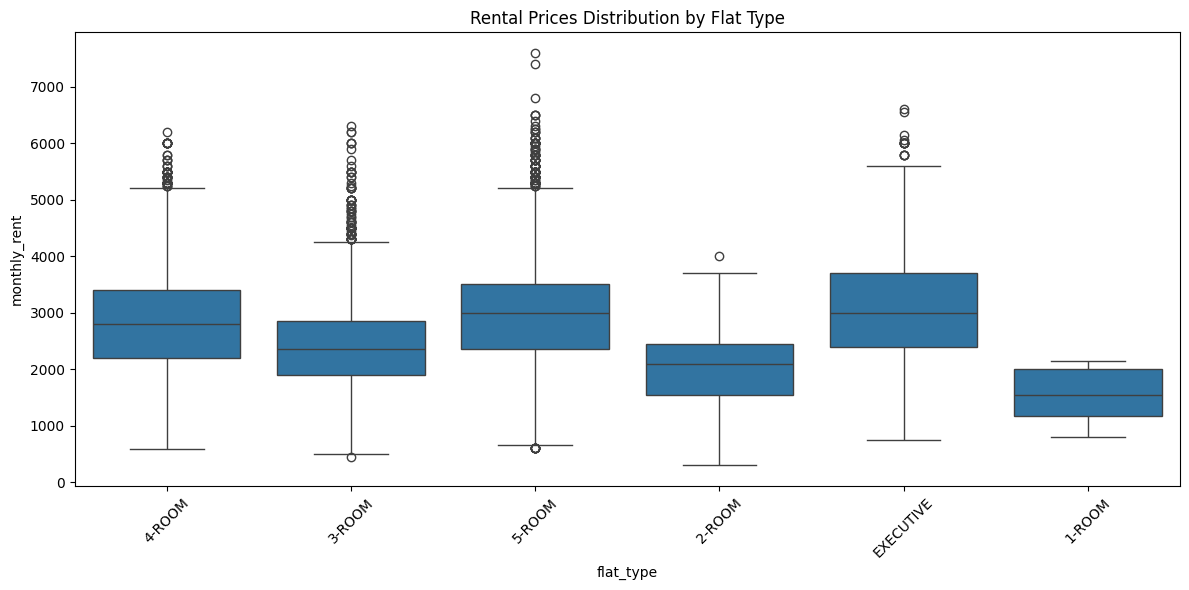

<Figure size 1200x800 with 0 Axes>

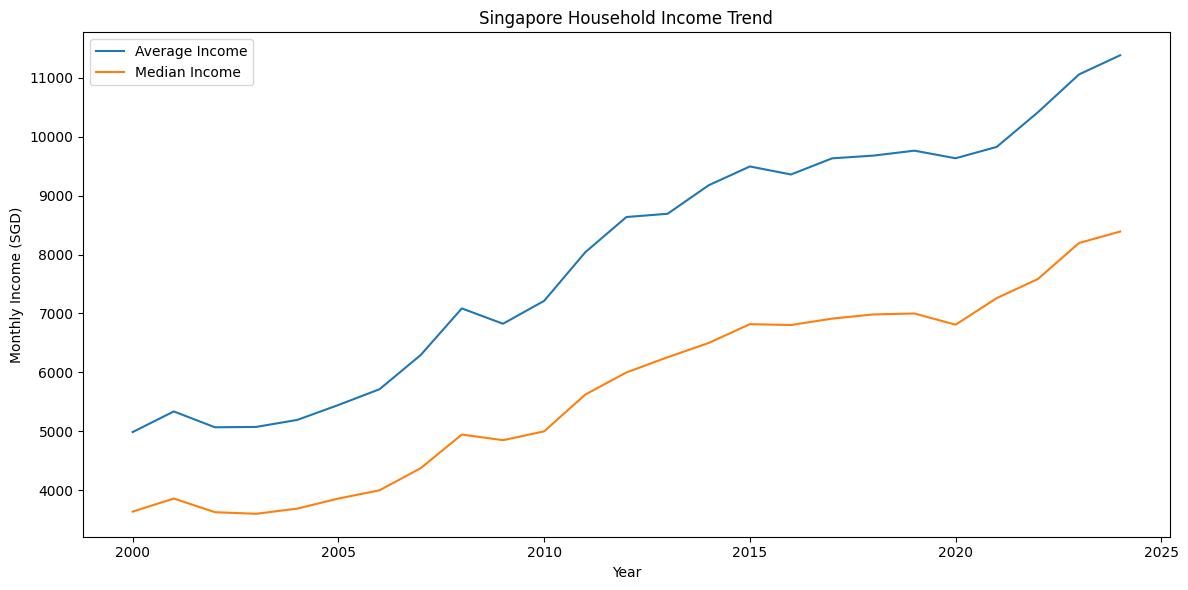

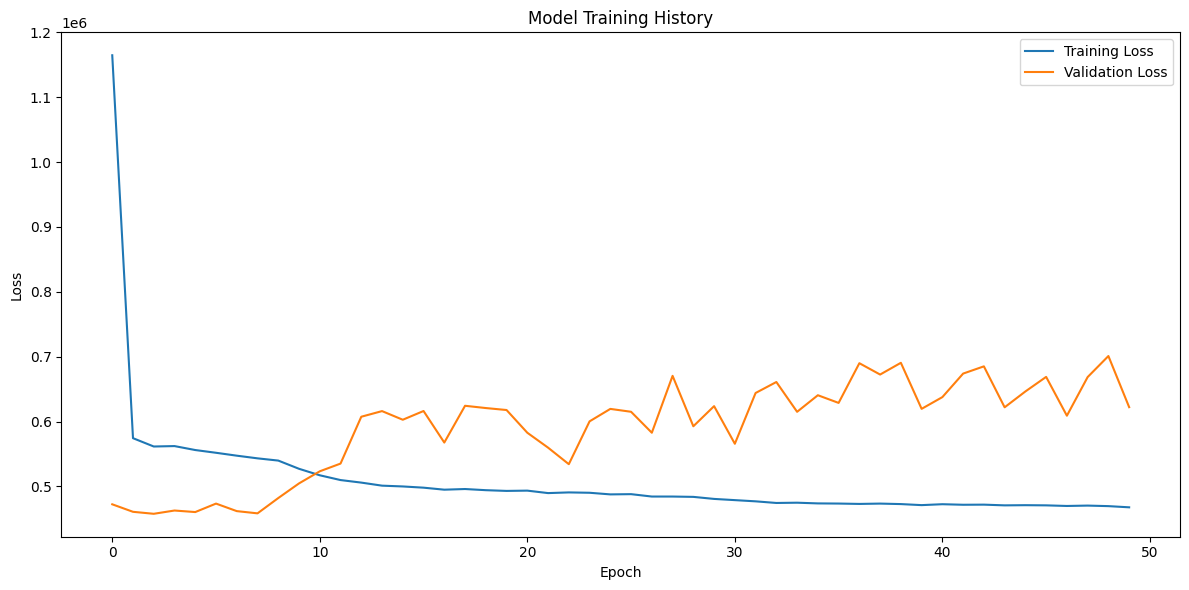

In [2]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
import folium
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load the datasets
def load_data():
    rental_df = pd.read_csv('RentingOutofFlats2025.csv')
    mrt_df = pd.read_csv('mrt_station.csv')
    income_df = pd.read_csv('monthly household income.csv')
    return rental_df, mrt_df, income_df

# Data preprocessing
def preprocess_rental_data(rental_df):
    # Convert date
    rental_df['rent_approval_date'] = pd.to_datetime(rental_df['rent_approval_date'])

    # Encode categorical variables
    le = LabelEncoder()
    rental_df['town_encoded'] = le.fit_transform(rental_df['town'])
    rental_df['flat_type_encoded'] = le.fit_transform(rental_df['flat_type'])
    rental_df['region_encoded'] = le.fit_transform(rental_df['region'])

    return rental_df

# Calculate distance to nearest MRT
def calculate_mrt_distance(rental_df, mrt_df):
    from sklearn.metrics.pairwise import haversine_distances

     # Drop rows with missing latitude or longitude in both dataframes before calculation
    rental_df = rental_df.dropna(subset=['latitude', 'longitude'])
    mrt_df = mrt_df.dropna(subset=['latitude', 'longitude'])

    def find_nearest_mrt(row):
        rental_coords = np.array([[row['latitude'], row['longitude']]])
        mrt_coords = mrt_df[['latitude', 'longitude']].values

        distances = haversine_distances(np.radians(rental_coords),
                                      np.radians(mrt_coords))[0] * 6371  # Earth radius in km

        return distances.min()

    rental_df['nearest_mrt_km'] = rental_df.apply(find_nearest_mrt, axis=1)
    return rental_df

# Visualization functions
def create_visualizations(rental_df, mrt_df, income_df):
    # 1. Rental prices distribution by flat type
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='flat_type', y='monthly_rent', data=rental_df)
    plt.title('Rental Prices Distribution by Flat Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('rental_distribution.png')

    # 2. Rental prices heatmap
    plt.figure(figsize=(12, 8))
    singapore_map = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

    # Add rental points with prices
    for idx, row in rental_df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=f"Rent: ${row['monthly_rent']}",
            color='red',
            fill=True
        ).add_to(singapore_map)

    singapore_map.save('rental_heatmap.html')

    # 3. Income trend over years
    plt.figure(figsize=(12, 6))
    plt.plot(income_df['year'], income_df['average'], label='Average Income')
    plt.plot(income_df['year'], income_df['medium'], label='Median Income')
    plt.title('Singapore Household Income Trend')
    plt.xlabel('Year')
    plt.ylabel('Monthly Income (SGD)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('income_trend.png')

# Prepare data for deep learning
def prepare_model_data(rental_df):
    features = ['town_encoded', 'flat_type_encoded', 'region_encoded',
                'nearest_mrt_km', 'latitude', 'longitude']
    X = rental_df[features]
    y = rental_df['monthly_rent']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Create and train deep learning model
def create_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    # Load data
    print("Loading datasets...")
    rental_df, mrt_df, income_df = load_data()

    # Preprocess data
    print("Preprocessing rental data...")
    rental_df = preprocess_rental_data(rental_df)

    # Calculate MRT distances
    print("Calculating distances to MRT stations...")
    rental_df = calculate_mrt_distance(rental_df, mrt_df)

    # Create visualizations
    print("Creating visualizations...")
    create_visualizations(rental_df, mrt_df, income_df)

    # Prepare data for modeling
    print("Preparing data for modeling...")
    X_train_scaled, X_test_scaled, y_train, y_test = prepare_model_data(rental_df)

    # Create and train model
    print("Training model...")
    model = create_model(input_shape=(X_train_scaled.shape[1],))
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1
    )

    # Evaluate model
    print("Evaluating model...")
    test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test MAE: ${test_mae:.2f}")

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')

if __name__ == "__main__":
    main()